#Classification

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model  import LogisticRegression

import os
import cv2
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score, homogeneity_score, completeness_score, silhouette_score
from sklearn.manifold import TSNE
from scipy import stats

In [2]:
file_path = '/content/drive/My Drive/programming/leaf-classification-clustering/data/leaves.csv'
df = pd.read_csv(file_path, header=None)
column_names = [f'feature_{i}' for i in range(df.shape[1])]
df.columns = column_names

print(df.head())
print(df.shape)

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0          1          1    0.72694     1.4742    0.32396    0.98535   
1          1          2    0.74173     1.5257    0.36116    0.98152   
2          1          3    0.76722     1.5725    0.38998    0.97755   
3          1          4    0.73797     1.4597    0.35376    0.97566   
4          1          5    0.82301     1.7707    0.44462    0.97698   

   feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
0    1.00000    0.83592   0.004657   0.003947    0.047790    0.127950   
1    0.99825    0.79867   0.005242   0.005002    0.024160    0.090476   
2    1.00000    0.80812   0.007457   0.010121    0.011897    0.057445   
3    1.00000    0.81697   0.006877   0.008607    0.015950    0.065491   
4    1.00000    0.75493   0.007428   0.010042    0.007938    0.045339   

   feature_12  feature_13  feature_14  feature_15  
0    0.016108    0.005232    0.000275     1.17560  
1    0.008119    0.002708    0

In [3]:
df.describe()  # Get summary statistics

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
count,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,18.544118,6.282353,0.719854,2.440210,0.513760,0.904158,0.943793,0.531234,0.037345,0.523845,0.051346,0.124535,0.017670,0.005928,0.000387,1.162630
std,11.152514,3.462779,0.208311,2.599043,0.195583,0.114639,0.115047,0.217532,0.038575,1.039639,0.035965,0.051860,0.013755,0.005294,0.000431,0.584854
min,1.000000,1.000000,0.117080,1.006600,0.107610,0.485490,0.396490,0.078376,0.002837,0.001464,0.005022,0.033415,0.001115,0.000229,0.000007,0.169400
25%,9.000000,3.000000,0.550623,1.211300,0.349623,0.890667,0.966230,0.346818,0.009521,0.016500,0.022843,0.083362,0.006901,0.002080,0.000102,0.718900
50%,15.000000,6.000000,0.763450,1.570750,0.501855,0.948130,0.992980,0.579160,0.023860,0.103615,0.042087,0.119375,0.014050,0.004447,0.000239,1.077450
75%,29.000000,9.000000,0.895097,2.343100,0.633373,0.976897,1.000000,0.700713,0.047834,0.416432,0.073046,0.163795,0.026127,0.008307,0.000516,1.554575
max,36.000000,16.000000,0.998710,19.038000,0.948340,0.993880,1.000000,0.858160,0.198980,7.206200,0.190670,0.280810,0.073089,0.029786,0.002936,2.708500


In [4]:
root_folder = '/content/drive/My Drive/programming/leaf-classification-clustering/data/leaves'

unique_classes = df['feature_0'].unique()

def load_images(root_folder, df):
    images = []
    for index, row in df.iterrows():
        class_number = int(row['feature_0'])
        image_number = int(row['feature_1'])
        image_name = f"iPAD2_C{class_number:02d}_EX{image_number:02d}.JPG"
        class_folder = os.path.join(root_folder, f"{class_number}. {row['class_Name']}")
        image_path = os.path.join(class_folder, image_name)
        if os.path.exists(image_path):
            image = io.imread(image_path)
            image = color.rgb2gray(image)
            images.append(image)
        else:
            images.append(None)  # Handle missing images appropriately
    return images

class_name_mapping = {
    1: "Quercus suber",
    2: "Salix atrocinerea",
    3: "Populus nigra",
    4: "Alnus sp",
    5: "Quercus robur",
    6: "Crataegus monogyna",
    7: "Ilex aquifolium",
    8: "Nerium oleander",
    9: "Betula pubescens",
    10: "Tilia tomentosa",
    11: "Acer palmaturu",
    12: "Celtis sp",
    13: "Corylus avellana",
    14: "Castanea sativa",
    15: "Populus alba",
    22: "Primula vulgaris",
    23: "Erodium sp",
    24: "Bougainvillea sp",
    25: "Arisarum vulgare",
    26: "Euonymus japonicus",
    27: "Ilex perado ssp azorica",
    28: "Magnolia soulangeana",
    29: "Buxus sempervirens",
    30: "Urtica dioica",
    31: "Podocarpus sp",
    32: "Acca sellowiana",
    33: "Hydrangea sp",
    34: "Pseudosasa japonica",
    35: "Magnolia grandiflora",
    36: "Geranium sp"
}
df['class_Name'] = df['feature_0'].map(class_name_mapping)
# Load the images
images = load_images(root_folder, df)

In [ ]:
def extract_texture_features(image):
    if image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    # Compute GLCM
    glcm = greycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    # Compute texture features
    contrast = greycoprops(glcm, prop='contrast')[0, 0]
    dissimilarity = greycoprops(glcm, prop='dissimilarity')[0, 0]
    homogeneity = greycoprops(glcm, prop='homogeneity')[0, 0]
    energy = greycoprops(glcm, prop='energy')[0, 0]
    correlation = greycoprops(glcm, prop='correlation')[0, 0]

    return [contrast, dissimilarity, homogeneity, energy, correlation]

# Extract texture features for all images
texture_features = []
for image in images:
    if image is not None:
        features = extract_texture_features(image)
        texture_features.append(features)
    else:
        texture_features.append([np.nan] * 5)  # Handle missing images appropriately

texture_features_df = pd.DataFrame(texture_features, columns=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'])

In [6]:
texture_features_df.describe()

,contrast,dissimilarity,homogeneity,energy,correlation
count,340.000000,340.000000,340.000000,340.000000,340.000000
mean,58.893012,3.899153,0.293202,0.038286,0.942606
std,41.657102,1.117695,0.043170,0.005703,0.039175
min,11.059983,2.147788,0.181995,0.023897,0.723558
25%,32.219364,3.130344,0.265561,0.034866,0.930247
50%,46.779621,3.528086,0.298368,0.038631,0.954020
75%,69.790907,4.480342,0.324058,0.041985,0.967436
max,280.013004,8.790498,0.393814,0.060580,0.987531


In [78]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model  import LogisticRegression

# Concatenate the original dataset with the new texture features
df_combined = pd.concat([df, texture_features_df], axis=1)

# Split the data into features and target
X = df_combined.drop(columns=['feature_0','feature_1','class_Name'])
y = df_combined['feature_0']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

clf = Pipeline([
  ('feature_selection', SelectFromModel(estimator=LogisticRegression())),
  ('classification', ExtraTreesClassifier(n_estimators=65, random_state=43))
])
clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9705882352941176


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         2
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          22       0.50      1.00      0.67         1
          23       1.00      1.00      1.00         1
          24       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:


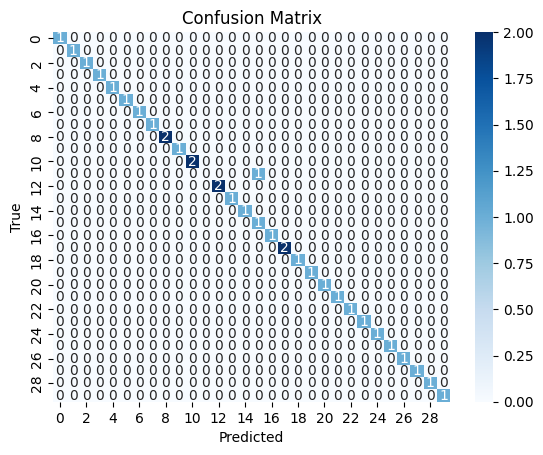

In [61]:
print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Clustering

In [130]:
# Standardizing the features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Clip outliers
X_scaled = np.clip(X_scaled, -3, 3)


# Applying PCA
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)

In [133]:
agglo = AgglomerativeClustering(n_clusters=30)
agglo_labels = agglo.fit_predict(X_pca)

# Evaluate Agglomerative Clustering
homogeneity_agglo = homogeneity_score(y, agglo_labels)
completeness_agglo = completeness_score(y, agglo_labels)
v_measure_agglo = v_measure_score(y, agglo_labels)
ari_agglo = adjusted_rand_score(y, agglo_labels)
nmi_agglo = normalized_mutual_info_score(y, agglo_labels)
silhouette_avg = silhouette_score(X_pca, agglo_labels)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Agglomerative Clustering Homogeneity: {homogeneity_agglo:.2f}')
print(f'Agglomerative Clustering Completeness: {completeness_agglo:.2f}')
print(f'Agglomerative Clustering V-measure: {v_measure_agglo:.2f}')
print(f'Agglomerative Clustering Adjusted Rand Index: {ari_agglo:.2f}')
print(f'Agglomerative Clustering Normalized Mutual Information: {nmi_agglo:.2f}')

Silhouette Score: 0.2824671604156972
Agglomerative Clustering Homogeneity: 0.74
Agglomerative Clustering Completeness: 0.77
Agglomerative Clustering V-measure: 0.75
Agglomerative Clustering Adjusted Rand Index: 0.42
Agglomerative Clustering Normalized Mutual Information: 0.75


# Clusters and Classes relation

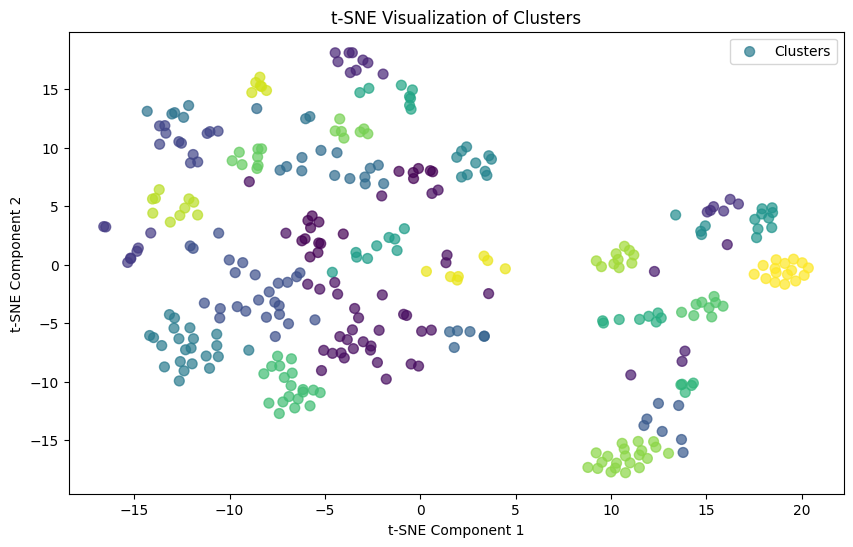

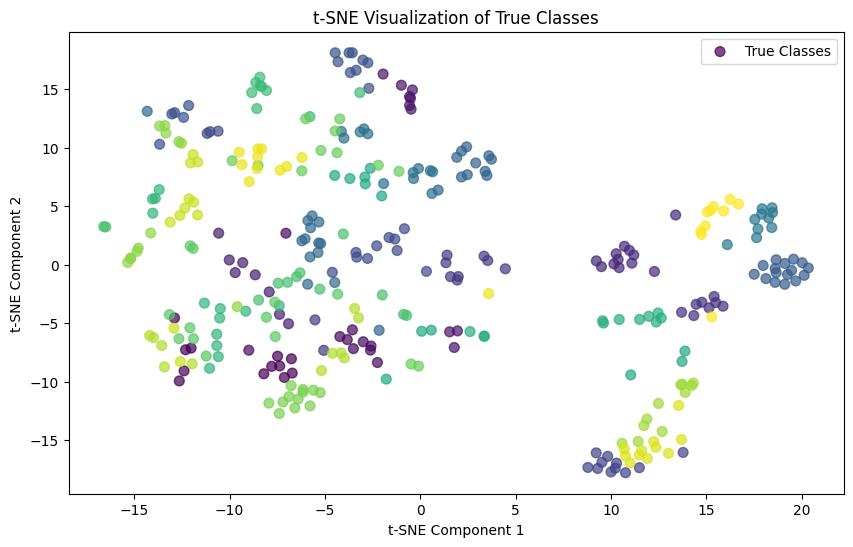

In [82]:
# Visualize the clusters and true classes using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=agglo_labels, cmap='viridis', s=50, alpha=0.7, label='Clusters')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50, alpha=0.7, label='True Classes')
plt.title('t-SNE Visualization of True Classes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()